## HW 5 - Page Rank
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Summer 2022`__

In Weeks 9 and 10 you discussed key concepts related to graph based algorithms and implemented SSSP.   
In this final homework assignment you'll implement distributed PageRank using some data from Wikipedia.
By the end of this homework you should be able to:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions underwhich it will converge.
* ... __identify__ what modifications must be made to the web graph inorder to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.

__Please refer to the `README` for homework submission instructions and additional resources.__

### Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

### Start Spark and the Spark UI

In [3]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
import os

try:
    spark
except NameError:
    print('starting Spark')
    app_name = 'Lab6_notebook'
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
sc = spark.sparkContext

ZONE = os.getenv("ZONE") #new as of June 17, 2022 4:45PM PST; restart cluster to see thus env variable
spark_UI_info = f'''
To start the SPARK UI

Copy the following command  to cloud shell and run as shown in the screenshot below. 
And click on the PREVIEW ON PORT 8080 menu option .
Run the following command to establish the SSH Tunnel:

gcloud compute ssh w261-m --zone {ZONE} --ssh-flag "-L 8080:localhost:4040" '''

print(spark_UI_info)

starting Spark
:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
graphframes#graphframes added as a dependency
org.apache.spark#spark-avro_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0bffe396-a8bf-4f08-9398-e0ed59b68a30;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.1-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
	found org.apache.spark#spark-avro_2.12;3.1.3 in central
	found org.spark-project.spark#unused;1.0.0 in central
downloading https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.1-s_2.12/graphframes-0.8.2-spark3.1-s_2.12.jar ...
	[SUCCESSFUL ] graphframes#graphframes;0.8.2-spark3.1-s_2.12!graphframes.jar (53ms)
downloading https://repo1.maven.org/maven2/org/apache/spark/spark-avro_2.12/3.1.3/spark-avro_2.12-3.1.3.jar ...
	[SUCCESSFUL ] org.apache.spark#spark-avro_2.12;3.1.3!spark-avro_2.12.jar (23ms)
downloading https://repo1.maven.org/ma


To start the SPARK UI

Copy the following command  to cloud shell and run as shown in the screenshot below. 
And click on the PREVIEW ON PORT 8080 menu option .
Run the following command to establish the SSH Tunnel:

gcloud compute ssh w261-m --zone us-central1-a --ssh-flag "-L 8080:localhost:4040" 


<img src='https://www.dropbox.com/s/tlb4uiakj2bx7qg/Three_steps_launch_SparkUI.png?raw=true' style='width:100%'>

## Set up global variables for cloud buckets (both Data, Staging) and for Zone 

In [4]:
# Access your personal data bucket and see whats there
# (RUN THIS CELL AS IS)
import os
DATA_BUCKET = os.getenv('DATA_BUCKET','')[:-1] # our private storage bucket location
HW5_FOLDER = f"{DATA_BUCKET}/main/Assignments/HW5/docker/student/data/"
print(f"Personal Data bucket:  {DATA_BUCKET}")
!gsutil ls -lh  {HW5_FOLDER}  #lets have a look the HW folder on our private storage bucket
print(f"STAGING_BUCKET location: {os.getenv('STAGING_BUCKET')}")
!gsutil ls -lh {os.getenv("STAGING_BUCKET")}notebooks/jupyter

Personal Data bucket:  gs://jstilb-hw
     167 B  2022-07-23T18:42:24Z  gs://jstilb-hw/main/Assignments/HW5/docker/student/data/test_graph.txt
                                 gs://jstilb-hw/main/Assignments/HW5/docker/student/data/all-pages-indexed-in/
                                 gs://jstilb-hw/main/Assignments/HW5/docker/student/data/all-pages-indexed-out/
                                 gs://jstilb-hw/main/Assignments/HW5/docker/student/data/indices/
TOTAL: 1 objects, 167 bytes (167 B)
STAGING_BUCKET location: gs://dataproc-staging-us-central1-984930941890-az8uneen/
       0 B  2022-05-07T15:49:39Z  gs://dataproc-staging-us-central1-984930941890-az8uneen/notebooks/jupyter/
                                 gs://dataproc-staging-us-central1-984930941890-az8uneen/notebooks/jupyter/snapshots/
                                 gs://dataproc-staging-us-central1-984930941890-az8uneen/notebooks/jupyter/student-workspace/
                                 gs://dataproc-staging-us-central

In [5]:
sc = spark.sparkContext
spark

# Question 1: Distributed Graph Processing
Chapter 5 from Lin & Dyer gave you a high level introduction to graph algorithms and concernts that come up when trying to perform distributed computations over them. The questions below are designed to make sure you captured the key points from this reading and your async lectures. 

### Q1 Tasks:

* __a) short response:__ Give an example of a dataset that would be appropriate to represent as a graph. What are the nodes/edges in this dataset? Is the graph you describe 'directed' or 'undirected'? What would the average "in-degree" of a node mean in the context of your example? 

* __b) Canvas MC:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm? *(__HINT__: Do not respond in terms of any specific algorithm. Think in terms of the nature of the graph datastructure itself).*

* __c) Canvas Fill In Blank:__ What specific design component in Dijkstra's algorithm makes this approach hard to parallelize?

* __d) short response:__ How does parallel breadth-first-search get around the problem that you identified in part `c`? At what expense?

### Q1 Student Answers:
> __a)__ Type your answer here!

> __b)__ Type your answer here!

> __c)__ Type your answer here!  

> __d)__ Type your answer here!

### <--- SOLUTION --->


# Question 2: Representing Graphs 

In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of $n_1$, $n_2$, etc but otherwise you should be able to follow along & check our answers against those in the text.


<img src="https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/Lin-Dyer-graph-Q1.png?raw=true" width=50%>

### Q2 Tasks:

* __a) short response:__ Relatively speaking, is the graph you described in Figure 5.1 in Lin & Dyer "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph.

* __b) short response:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.

* __c) code:__ Fill in the missing code to complete the function `get_adj_matr()`.

* __d) code:__ Fill in the missing code to complete the function `get_adj_list()`.

### Q2 Student Answers:
> __a)__ Type your answer here!

> __b)__ Type your answer here!

### <--- SOLUTION --->


In [6]:
# part a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

None

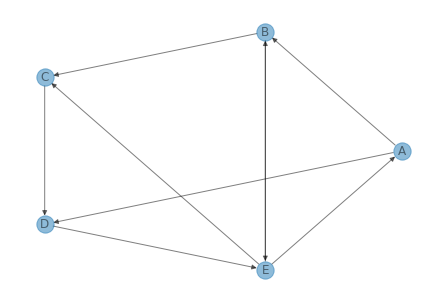

In [7]:
# part a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [8]:
# part c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################
    for edge in graph['edges']:
        adj_matr.loc[edge[0],edge[1]] = 1
    ############### (END) YOUR CODE #################
    return adj_matr

In [9]:
# part c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

   A  B  C  D  E
A  0  1  0  1  0
B  0  0  1  0  1
C  0  0  0  1  0
D  0  0  0  0  1
E  1  1  1  0  0


In [10]:
# part d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################
    for edge in graph['edges']:
        adj_list[edge[0]].append(edge[1])
    
    ############### (END) YOUR CODE #################
    return adj_list

In [11]:
# part d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

{'A': ['B', 'D'], 'B': ['C', 'E'], 'C': ['D'], 'D': ['E'], 'E': ['A', 'B', 'C']}


# Question 3: Markov Chains and Random Walks

As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

### Q3 Tasks:

* __a) short response:__ It is common to explain PageRank using the analogy of a web surfer who clicks on links at random ad infinitum. In the context of this hypothetical infinite random walk, what does the PageRank metric measure/represent?

* __b) Canvas Multiple Drowpdowns:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) Canvas Multiple Fill In Blank:__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph what are the $n$ states? what implications does this have about the size of the transition matrix?

* __d) Canvas MC:__ What is a "right stochastic matrix"?

* __e) code:__ Fill in the code below to compute the transition matrix for the toy graph from question 2. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __f) code:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. 
    * __`NOTE 1:`__ _this is a naive approach, we'll unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.

* __g) Numerical Answer:__ How many iterations does it take to converge? 

* __h) Canvas Multiple Choice:__ Which node is most 'central' (i.e. highest ranked)?


### Q3 Student Answers:

### <--- SOLUTION --->


In [ ]:
# part e - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

In [12]:
# part e - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE #################
transition_matrix = (TOY_ADJ_MATR.T / TOY_ADJ_MATR.sum(axis=1)).T

################ (END) YOUR CODE #################
print(transition_matrix)

          A         B         C    D    E
A  0.000000  0.500000  0.000000  0.5  0.0
B  0.000000  0.000000  0.500000  0.0  0.5
C  0.000000  0.000000  0.000000  1.0  0.0
D  0.000000  0.000000  0.000000  0.0  1.0
E  0.333333  0.333333  0.333333  0.0  0.0


In [13]:
# part f - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing inial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    ################ YOUR CODE HERE #################
    state_vector = xInit
    exp = 1
    
    for i in range(nIter):
        for x in range(exp):
            state_vector = state_vector@tMatrix
        exp = exp*2
        
        if verbose:
            print(f'Step {i}: {state_vector}')
            
    return state_vector
    
    
    
    ################ (END) YOUR CODE #################
    return state_vector

In [14]:
# part f - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 10, verbose = True)

Step 0: A    0.0
B    0.5
C    0.0
D    0.5
E    0.0
dtype: float64
Step 1: A    0.25
B    0.25
C    0.25
D    0.25
E    0.00
dtype: float64
Step 2: A    0.062500
B    0.135417
C    0.166667
D    0.281250
E    0.354167
dtype: float64
Step 3: A    0.105754
B    0.159485
C    0.184659
D    0.238510
E    0.311592
dtype: float64
Step 4: A    0.105261
B    0.157891
C    0.184209
D    0.236839
E    0.315800
dtype: float64
Step 5: A    0.105263
B    0.157895
C    0.184211
D    0.236842
E    0.315789
dtype: float64
Step 6: A    0.105263
B    0.157895
C    0.184211
D    0.236842
E    0.315789
dtype: float64
Step 7: A    0.105263
B    0.157895
C    0.184211
D    0.236842
E    0.315789
dtype: float64
Step 8: A    0.105263
B    0.157895
C    0.184211
D    0.236842
E    0.315789
dtype: float64
Step 9: A    0.105263
B    0.157895
C    0.184211
D    0.236842
E    0.315789
dtype: float64


__`Expected Output for part e:`__  
>Steady State Probabilities:
```
Node A: 0.10526316  
Node B: 0.15789474  
Node C: 0.18421053  
Node D: 0.23684211  
Node E: 0.31578947  
```

# Question 4: Page Rank Theory

Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' in Question 3 and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from question 3 on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q4 Tasks:

* __a) code:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from question 3.

* __b) Canvas MCQ:__ What is wrong with what you see in part a? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __c) Canvas MCQ:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __d) Canvas MCQ:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Choose your reasoning.

* __e) Canvas MCQ:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Choose your reasoning.

* __f) short response:__ What modification to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? Interpret this modification in terms of our random surfer analogy.

### Q4 Student Answers:

> __b)__ Type your answer here!

> __c)__ Type your answer here!

> __d)__ Type your answer here!  

> __e)__ Type your answer here!

> __f)__ Type your answer here!

### <--- SOLUTION --->


In [15]:
# part a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

None

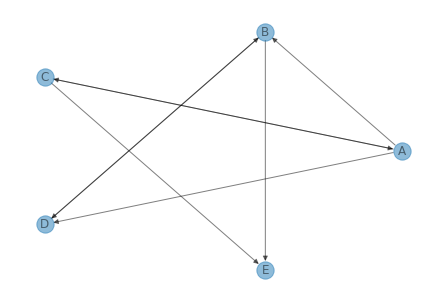

In [16]:
# part a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [17]:
# part a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################
TOY2_ADJ_MATR = get_adj_matr(TOY2_GRAPH)
transition_matrix = ((TOY2_ADJ_MATR.T / TOY2_ADJ_MATR.sum(axis=1)).T).fillna(0)
power_iteration(xInit, transition_matrix, 10, verbose = True)



################ (END) YOUR CODE #################

Step 0: A    0.000000
B    0.333333
C    0.333333
D    0.333333
E    0.000000
dtype: float64
Step 1: A    0.000000
B    0.222222
C    0.055556
D    0.222222
E    0.166667
dtype: float64
Step 2: A    0.000000
B    0.061728
C    0.001543
D    0.061728
E    0.060185
dtype: float64
Step 3: A    0.000000
B    0.003906
C    0.000001
D    0.003906
E    0.003904
dtype: float64
Step 4: A    0.000000e+00
B    1.525879e-05
C    7.089408e-13
D    1.525879e-05
E    1.525879e-05
dtype: float64
Step 5: A    0.000000e+00
B    2.328306e-10
C    2.512986e-25
D    2.328306e-10
E    2.328306e-10
dtype: float64
Step 6: A    0.000000e+00
B    5.421011e-20
C    3.157548e-50
D    5.421011e-20
E    5.421011e-20
dtype: float64
Step 7: A     0.000000e+00
B     2.938736e-39
C    4.985055e-100
D     2.938736e-39
E     2.938736e-39
dtype: float64
Step 8: A     0.000000e+00
B     8.636169e-78
C    1.242539e-199
D     8.636169e-78
E     8.636169e-78
dtype: float64
Step 9: A     0.000000e+00
B    7.458341e-155
C     0

A     0.000000e+00
B    7.458341e-155
C     0.000000e+00
D    7.458341e-155
E    7.458341e-155
dtype: float64

# About the Data
The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here: 
> https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data. 

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation(note that we'll use the 'indexed out' version of the graph) and to take a look at the files.

In [18]:
HW5_FOLDER

'gs://jstilb-hw/main/Assignments/HW5/docker/student/data/'

In [19]:
!gsutil ls -l {HW5_FOLDER}

       167  2022-07-23T18:42:24Z  gs://jstilb-hw/main/Assignments/HW5/docker/student/data/test_graph.txt
                                 gs://jstilb-hw/main/Assignments/HW5/docker/student/data/all-pages-indexed-in/
                                 gs://jstilb-hw/main/Assignments/HW5/docker/student/data/all-pages-indexed-out/
                                 gs://jstilb-hw/main/Assignments/HW5/docker/student/data/indices/
TOTAL: 1 objects, 167 bytes (167 B)


In [20]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
testRDD = sc.textFile(HW5_FOLDER +'test_graph.txt')
indexRDD = sc.textFile(HW5_FOLDER + '/indices/')
wikiRDD = sc.textFile(HW5_FOLDER + '/all-pages-indexed-out/')

In [21]:
# display testRDD (RUN THIS CELL AS IS)
testRDD.take(10)

["2\t{'3': 1}",
 "3\t{'2': 2}",
 "4\t{'1': 1, '2': 1}",
 "5\t{'4': 3, '2': 1, '6': 1}",
 "6\t{'2': 1, '5': 2}",
 "7\t{'2': 1, '5': 1}",
 "8\t{'2': 1, '5': 1}",
 "9\t{'2': 1, '5': 1}",
 "10\t{'5': 1}",
 "11\t{'5': 2}"]

In [22]:
# display indexRDD (RUN THIS CELL AS IS)
indexRDD.take(10)

['! $var = &quot;&quot;\t1\t1\t0',
 '! (CONFIG.SYS directive)\t2\t1\t1',
 '! (album)\t3\t12\t17',
 '! (disambiguation)\t4\t1\t20',
 '! -attention-\t5\t1\t0',
 '! Time Zone\t6\t1\t0',
 '!! (chess)\t7\t0\t1',
 '!! (disambiguation)\t8\t3\t0',
 '!!! (Chk Chk Chk)\t9\t1\t0',
 '!!! (album)\t10\t5\t15']

In [23]:
# display wikiRDD (RUN THIS CELL AS IS)
wikiRDD.take(10)

["73\t{'14417532': 1}",
 "299\t{'4214575': 1}",
 "2552\t{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}",
 "2570\t{'983991': 1}",
 "2616\t{'9045350': 1}",
 "2711\t{'752887': 1}",
 "2818\t{'3534183': 1}",
 "2847\t{'3797918': 1}",
 "2892\t{'2893': 1}",
 "2921\t{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}"]

# Question 5: EDA part 1 (number of nodes)

As usual, before we dive in to the main analysis, we'll peform some exploratory data anlysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

### Q5 Tasks:
* __a) Canvas Matching:__ In what format is the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]

* __b) Canvas MC:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.

* __c) code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 

* __d) Numerical Answer:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

### Q5 Student Answers:

### <--- SOLUTION --->
__SOLUTION__


In [24]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
# 5781290
print(wikiRDD.count())

5781290


In [25]:
# part c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############
    def splitText(line):
        key, value = line.split("\t")
        new_dict = ast.literal_eval(value)
        new_dict[key] = 1
        for k, v in new_dict.items():
            yield (k, v)
    
    totalCount = dataRDD.map(splitText).flatMap(lambda x: x).reduceByKey(lambda x,y: x+y).count()
    
    
    
    ############## (END) YOUR CODE ###############   
    return totalCount

In [26]:
# part c - run your counting job on the test file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(testRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 0.7117912769317627 seconds.
Total Nodes: 11


In [27]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 86.59745788574219 seconds.
Total Nodes: 15192277


In [ ]:
# <--- SOLUTION --->
# part d - number of dangling nodes


In [ ]:
# <--- SOLUTION --->
# part d - number of dangling nodes


# Question 6 - EDA part 2 (out-degree distribution)

As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q6 Tasks:
* __a) code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
  * count the out-degree of each non-dangling node and return the names of the top 10 pages with the most hyperlinks
  * find the average out-degree for all non-dangling nodes in the graph
  * take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
 
 
* __b) short response:__ In the context of the PageRank algorithm, how is information about a node's out degree used?

* __c) short response:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others?
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q6 Student Answers:

> __b)__ Type your answer here! 

> __c)__ Type your answer here!

### <--- SOLUTION --->
__SOLUTION__


In [28]:
# part a - write your Spark job here (compute average in-degree, etc)
def count_degree(dataRDD, n):
    """
    Function to analyze out-degree of nodes in a a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    # helper func
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    ############## YOUR CODE HERE ###############
    edge_counts = dataRDD.map(parse).map(lambda x: [(x[0], sum(x[1].values()))]).flatMap(lambda x: x).reduceByKey(lambda x,y: x+y)
    
    # sort counts
    sorted_counts = edge_counts.sortBy(lambda x: x[1]).collect()
    
    # get n nodes with most out-edges
    top = list(reversed(sorted_counts[-n:]))
   
    # get average out-degree for non-dangling nodes
    avgDegree = edge_counts.flatMap(lambda x: [x[1]]).mean()

    # get out-degree for n randomly sampled non-dangling nodes
    sampledCounts = edge_counts.flatMap(lambda x: [x[1]]).sample(False, 1, 81).take(n)
    
    
    
    
    ############## (END) YOUR CODE ###############
    
    return top, avgDegree, sampledCounts

In [29]:
# part a - run your job on the test file (RUN THIS CELL AS IS)
start = time.time()
test_results = count_degree(testRDD,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])

... completed job in 0.3889622688293457 seconds
Average out-degree:  2.2
Top 10 nodes (by out-degree:)
 [('5', 5), ('6', 3), ('11', 2), ('7', 2), ('3', 2), ('9', 2), ('8', 2), ('4', 2), ('2', 1), ('10', 1)]


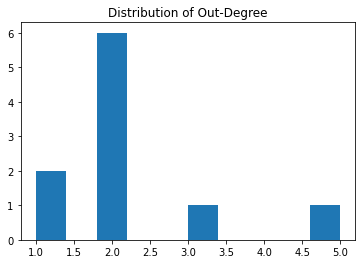

None

In [30]:
# part a - plot results from test file (RUN THIS CELL AS IS)
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
display(plt.show())

In [31]:
# part a - run your job on the full file (RUN THIS CELL AS IS)
start = time.time()
full_results = count_degree(wikiRDD,1000)

print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])

... completed job in 69.90621829032898 seconds
Average out-degree:  32.04181575392334
Top 10 nodes (by out-degree:)
 [('7804599', 9347), ('7858931', 8910), ('11185362', 8837), ('7705822', 8142), ('5760310', 7649), ('7865920', 7608), ('7819767', 7278), ('7883280', 7231), ('13035895', 7126), ('7880980', 6904), ('7909437', 6599), ('7810869', 6486), ('7846493', 6386), ('7841582', 6379), ('7768780', 6211), ('7820711', 6180), ('7861935', 6102), ('6075450', 6021), ('7884831', 6005), ('7777185', 5984), ('7803276', 5881), ('6074992', 5870), ('434078', 5856), ('7828359', 5853), ('7773411', 5806), ('7834538', 5788), ('10526976', 5772), ('7828391', 5606), ('1008643', 5599), ('7873008', 5595), ('7812439', 5554), ('7881486', 5552), ('7773479', 5523), ('7820535', 5520), ('7871067', 5517), ('7882833', 5504), ('7902703', 5471), ('7847103', 5449), ('5988470', 5421), ('7872661', 5419), ('7914303', 5369), ('5988469', 5363), ('7848337', 5344), ('11670785', 5341), ('7884903', 5234), ('6075178', 5217), ('607

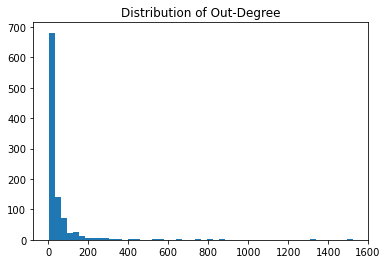

None

In [32]:
# part a - plot results from full file (RUN THIS CELL AS IS)
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
display(plt.show())

# Question 7 - PageRank part 1 (Initialize the Graph)

One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code $N$.

### Q7 Tasks:
* __a) Canvas MC:__ What is $N$? 

* __b) Canvas Multiple Selection MC:__ Using the analogy of the infinite random web-surfer, how do we use $\frac{1}{N}$?

* __c) Canvas Multiple Dropdown:__ Will it be more efficient to compute \\(N\\) before initializing records for each dangling node or after? (T/F).

* __d) code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it list of neighbors to be an empty set
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring


* __e) code + short answer:__ Run the provided code to confirm that your job in `part d` has a record for each node and that your should records match the format specified in the docstring and the count should match what you computed in question 5. Copy and paste this output into Canvas. [__`TIP:`__ _you might want to take a moment to write out what the expected output should be fore the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q7 Student Answers:

### <--- SOLUTION --->


In [102]:
# part d - job to initialize the graph (RUN THIS CELL AS IS)
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############

    # write any helper functions here
    def parseNeighbors(line):
        node, edges = line.split('\t')
        edges = ast.literal_eval(edges)
        edges = list(edges.keys())
        return (node, edges)

    
    # Loads all URLs from input RDD and initialize their neighbors.
    links = dataRDD.map(lambda urls: parseNeighbors(urls)).groupByKey().mapValues(list).cache()
    
    # Loads all nodes and initialize ranks of them to one.
    graphRDD = links.map(lambda neighbors: (neighbors[0], (1.0, neighbors[1][0])))
    
    
    ############## (END) YOUR CODE ##############
    
    return graphRDD

In [103]:
# part e - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 0.24186301231384277 seconds.


[('4', (1.0, ['1', '2'])),
 ('8', (1.0, ['2', '5'])),
 ('9', (1.0, ['2', '5'])),
 ('10', (1.0, ['5'])),
 ('2', (1.0, ['3'])),
 ('3', (1.0, ['2'])),
 ('5', (1.0, ['4', '2', '6'])),
 ('6', (1.0, ['2', '5'])),
 ('7', (1.0, ['2', '5'])),
 ('11', (1.0, ['5']))]

In [135]:
# part e - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 0.027193069458007812 seconds


In [ ]:
# part e - confirm record format and count (RUN THIS CELL AS IS)
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
print(f'First record: {wikiGraphRDD.take(1)}')
print(f'... initialization continued: {time.time() - start} seconds')

Total number of records: 5781290
First record: [('2051810', (1.0, ['12109271']))]
... initialization continued: 123.61452341079712 seconds


# Question 8 - PageRank part 2 (Iterate until convergence)

Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/PR-illustrated.png?raw=true' width=50%>



__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The $P$ on the left hand side of the equation is the new score, and the $P$ on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, $|G|$ is the number of nodes in the graph (which we've elsewhere refered to as $N$).

### Q8 Tasks:
* __a) Canvas MCQ:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $\alpha * \frac{1}{|G|}$

* __b) Canvas MCQ:__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?

* __c) Numeric answer:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) code:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies telportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.
  
   __WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q8 Student Answers:

> __a)__ Type your answer here!

> __b)__ Type your answer here! 

> __c)__ Type your answer here!

### <--- SOLUTION --->
__SOLUTION__



In [37]:
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS)

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [137]:
# part d - job to run PageRank (RUN THIS CELL AS IS)
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    ############## YOUR CODE HERE ###############
    
    num_nodes = graphInitRDD.count()
          
    def init_score(x):
        node = x[0]
        scores = x[1][0]
        edges =  x[1][1]
        num_edges = len(edges)
        temp_node = (node,(0,edges))
        if num_edges != 0:
            new_scores = scores/num_edges
            new_rdd = [(y,(new_scores,[])) for y in edges]
            new_rdd.append(temp_node)
            return new_rdd
        else:
            mmAccum.add(scores)
            return [(node,(0,[]))]
          
    def func_reduce(x,y):
        return (x[0]+y[0],x[1]+y[1])
      
    def final_score(x,mm):
        node = x[0]
        scores = x[1][0]
        edges =  x[1][1]
        final_scores = (a.value*(1/num_nodes)) + ((d.value) * (mm/num_nodes + scores))
        totAccum.add(final_scores)
        return (node,(final_scores,edges))
    
    
    for i in range(maxIter) :
        graphInitRDD = graphInitRDD.flatMap(lambda x : init_score(x)).reduceByKey(lambda x,y:func_reduce(x,y)).cache()
        accum = float(mmAccum.value)
        graphInitRDD = graphInitRDD.map(lambda x : final_score(x,accum)).cache()
        mmAccum.value = 0
        totAccum.value = 0

    steadyStateRDD = graphInitRDD.map(lambda x: (x[0], x[1][0]))
    
    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

In [138]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = False)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])

...trained 20 iterations in 0.8508255481719971 seconds.
Top 20 ranked nodes:


[('3', 0.5144206251640965),
 ('2', 0.4567972647099972),
 ('5', 0.07503552877860711),
 ('4', 0.036260071356824825),
 ('6', 0.036260071356824825),
 ('1', 0.0304105287786071),
 ('8', 0.015),
 ('9', 0.015),
 ('10', 0.015),
 ('7', 0.015),
 ('11', 0.015)]

__`expected results for the test graph:`__
```
[(2, 0.3620640495978871),
 (3, 0.333992700474142),
 (5, 0.08506399429624555),
 (4, 0.06030963508473455),
 (1, 0.04255740809817991),
 (6, 0.03138662354831139),
 (8, 0.01692511778009981),
 (10, 0.01692511778009981),
 (7, 0.01692511778009981),
 (9, 0.01692511778009981),
 (11, 0.01692511778009981)]
```

In [139]:
# part d - run PageRank on the full graph (RUN THIS CELL AS IS)
# NOTE: wikiGraphRDD should have been computed & cached above!
nIter = 10
start = time.time()
full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
full_results.takeOrdered(20, key=lambda x: - x[1])

...trained 10 iterations in 3.1912152767181396 seconds.
Top 20 ranked nodes:


KeyboardInterrupt: 

In [ ]:
top_20 = full_results.takeOrdered(20, key=lambda x: - x[1])

In [144]:
# view record from indexRDD (RUN THIS CELL AS IS)
# title\t indx\t inDeg\t outDeg
indexRDD.take(1)

['! $var = &quot;&quot;\t1\t1\t0']

In [145]:
# map indexRDD to new format (index, name) (RUN THIS CELL AS IS)
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [146]:
# see new format (RUN THIS CELL AS IS)
namesKV_RDD.take(2)

[(1, '! $var = &quot;&quot;'), (2, '! (CONFIG.SYS directive)')]

In [141]:
# We should have saved these above, but it takes too long to run in the cloud ($$$), so for expedience:
top_20 = [(13455888, 0.0015447247129832947),
 (4695850, 0.0006710240718906518),
 (5051368, 0.0005983856809747697),
 (1184351, 0.0005982073536467391),
 (2437837, 0.0004624928928940748),
 (6076759, 0.00045509400641448284),
 (4196067, 0.0004423778888372447),
 (13425865, 0.00044155351714348035),
 (6172466, 0.0004224002001845032),
 (1384888, 0.0004012895604073632),
 (6113490, 0.00039578924771805474),
 (14112583, 0.0003943847283754762),
 (7902219, 0.000370098784735699),
 (10390714, 0.0003650264964328283),
 (12836211, 0.0003619948863114985),
 (6237129, 0.0003519555847625285),
 (6416278, 0.00034866235645266493),
 (13432150, 0.00033936510637418247),
 (1516699, 0.00033297500286244265),
 (7990491, 0.00030760906265869104)]

In [147]:
# (RUN THIS CELL AS IS)
top_20_RDD = sc.parallelize(top_20)

In [148]:
# (RUN THIS CELL AS IS)
top_20_RDD.take(1)

[(13455888, 0.0015447247129832947)]

Exception in thread "serve RDD 2800 with partitions 0" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


# Question 9 - Pretty Print

### Q9 Tasks
The indexRDD we created earlier from the indices.txt file contains the titles of the pages and their IDs.

* __a) code:__ Join this dataset with your top 20 results.
* __b) code:__ Print the results

Join with indexRDD and print pretty

In [151]:
# part a
joinedWithNames = None
############## YOUR CODE HERE ###############
joinedWithNames = namesKV_RDD.join(top_20_RDD).collect()
############## END YOUR CODE ###############

In [152]:
# part b
# Feel free to modify this cell to suit your implementation, but please keep the formatting and sort order.
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in joinedWithNames:
    print ("{:6f}\t| {:10d}\t| {}".format(r[1][1],r[0],r[1][0]))

PageRank  	| Page id   	| Title
0.000442	|    4196067	| England
0.000394	|   14112583	| World War II
0.000598	|    5051368	| Germany
0.000352	|    6237129	| Italy
0.000442	|   13425865	| United Kingdom
0.000671	|    4695850	| France
0.000370	|    7902219	| List of sovereign states
0.000462	|    2437837	| Canada
0.001545	|   13455888	| United States
0.000396	|    6113490	| Insect
0.000422	|    6172466	| Iran
0.000362	|   12836211	| The New York Times
0.000349	|    6416278	| Japan
0.000339	|   13432150	| United States Census Bureau
0.000455	|    6076759	| India
0.000401	|    1384888	| Arthropod
0.000365	|   10390714	| Poland
0.000333	|    1516699	| Australia
0.000308	|    7990491	| London
0.000598	|    1184351	| Animal


# Question 10 - GraphFrames
GraphFrames is a graph library which is built on top of the Spark DataFrames API.

### Q10 Tasks
* __a) code:__ Using the same dataset, run the graphframes implementation of pagerank.
* __b) code:__ Join the top 20 results with indices.txt and display in the same format as above.
* __c) short answer:__ Compare your results with the results from graphframes.

__NOTE:__ Feel free to create as many code cells as you need. Code should be clear and concise - do not include your scratch work. Comment your code if it's not self annotating.

In [153]:
!pip install graphframes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 1.2 MB/s eta 0:00:0000:01


In [164]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from graphframes import *
from pyspark.sql import functions as F

In [165]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
testRDD = sc.textFile(HW5_FOLDER +'test_graph.txt')
indexRDD = sc.textFile(HW5_FOLDER + '/indices/')
wikiRDD = sc.textFile(HW5_FOLDER + '/all-pages-indexed-out/')

In [166]:
DF = wikiRDD.map(lambda x: (x.split('\t')[0], ast.literal_eval(x.split('\t')[1]))).toDF()

In [157]:
%%time
DF.take(1)

CPU times: user 9.39 ms, sys: 0 ns, total: 9.39 ms
Wall time: 1.96 s


[Row(_1='73', _2={'14417532': 1})]

In [167]:
v = DF.select('_1').withColumnRenamed('_1','id').distinct().cache()

In [ ]:
%%time
v.show(1)

In [168]:
import ast
def getEdges(row):
    node_id, nodes = row
    for node in nodes: 
        yield int(node_id), int(node)

In [169]:
e = spark.createDataFrame(DF.rdd.flatMap(getEdges), ["src", "dst"]).cache()

In [161]:
%%time
e.show(1)

+---+--------+
|src|     dst|
+---+--------+
| 73|14417532|
+---+--------+
only showing top 1 row

CPU times: user 38.7 ms, sys: 4.52 ms, total: 43.3 ms
Wall time: 1min 12s


In [170]:
# Create a GraphFrame
# from graphframes import *
g = GraphFrame(v, e)

# Query: Get in-degree of each vertex.
# g.inDegrees.show()

In [172]:
# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.15, maxIter=10)

22/07/23 22:07:29 WARN org.apache.spark.rpc.netty.NettyRpcEnv: Ignored failure: java.util.concurrent.TimeoutException: Cannot receive any reply from w261-m.us-central1-a.c.w261-student-349323.internal:33645 in 10000 milliseconds
22/07/23 22:07:48 WARN org.apache.spark.executor.Executor: Issue communicating with driver in heartbeater
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [10000 milliseconds]. This timeout is controlled by spark.executor.heartbeatInterval
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:76)
	at org.apache.spark.rpc.RpcEndpointRef.askSync

Py4JJavaError: An error occurred while calling o17137.run.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 10 in stage 2135.0 failed 1 times, most recent failure: Lost task 10.0 in stage 2135.0 (TID 2384) (w261-m.us-central1-a.c.w261-student-349323.internal executor driver): java.lang.OutOfMemoryError: GC overhead limit exceeded
	at java.util.LinkedList.linkLast(LinkedList.java:142)
	at java.util.LinkedList.add(LinkedList.java:338)
	at org.apache.spark.sql.execution.BufferedRowIterator.append(BufferedRowIterator.java:73)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.graphx.EdgeRDD$.$anonfun$fromEdges$1(EdgeRDD.scala:107)
	at org.apache.spark.graphx.EdgeRDD$.$anonfun$fromEdges$1$adapted(EdgeRDD.scala:105)
	at org.apache.spark.graphx.EdgeRDD$$$Lambda$4222/1444697126.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndex$2(RDD.scala:915)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndex$2$adapted(RDD.scala:915)
	at org.apache.spark.rdd.RDD$$Lambda$3045/864922766.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.$anonfun$getOrCompute$1(RDD.scala:386)
	at org.apache.spark.rdd.RDD$$Lambda$2279/873057403.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1423)
	at org.apache.spark.storage.BlockManager$$Lambda$1324/1642399569.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1350)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1414)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1237)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:384)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:335)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2304)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2252)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2252)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1124)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2491)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2433)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2422)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:902)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2204)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2225)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2244)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2269)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$1(RDD.scala:1020)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.foreachPartition(RDD.scala:1018)
	at org.apache.spark.graphx.lib.PageRank$.runWithOptions(PageRank.scala:175)
	at org.graphframes.lib.PageRank$.run(PageRank.scala:130)
	at org.graphframes.lib.PageRank.run(PageRank.scala:104)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at java.util.LinkedList.linkLast(LinkedList.java:142)
	at java.util.LinkedList.add(LinkedList.java:338)
	at org.apache.spark.sql.execution.BufferedRowIterator.append(BufferedRowIterator.java:73)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.graphx.EdgeRDD$.$anonfun$fromEdges$1(EdgeRDD.scala:107)
	at org.apache.spark.graphx.EdgeRDD$.$anonfun$fromEdges$1$adapted(EdgeRDD.scala:105)
	at org.apache.spark.graphx.EdgeRDD$$$Lambda$4222/1444697126.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndex$2(RDD.scala:915)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndex$2$adapted(RDD.scala:915)
	at org.apache.spark.rdd.RDD$$Lambda$3045/864922766.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.$anonfun$getOrCompute$1(RDD.scala:386)
	at org.apache.spark.rdd.RDD$$Lambda$2279/873057403.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1423)
	at org.apache.spark.storage.BlockManager$$Lambda$1324/1642399569.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1350)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1414)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1237)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:384)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:335)


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 55476)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/miniconda3/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/miniconda3/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/miniconda3/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/lib/spark/python/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/usr/lib/spark/python/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/usr/lib/spark/python/pyspark/accumulators.py", line 239, in accum_updates
    num_updates = read_int(self.rfile

In [ ]:
start = time.time()
top_20 = results.vertices.orderBy(F.desc("pagerank")).limit(20)
print(f'... completed job in {time.time() - start} seconds.')

In [ ]:
%%time
top_20.show()

In [ ]:
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [ ]:
namesKV_DF = namesKV_RDD.toDF()

In [ ]:
namesKV_DF = namesKV_DF.withColumnRenamed('_1','id')
namesKV_DF = namesKV_DF.withColumnRenamed('_2','title')
namesKV_DF.take(1)

In [ ]:
resultsWithNames = namesKV_DF.join(top_20, namesKV_DF.id==top_20.id).orderBy(F.desc("pagerank")).collect()

In [ ]:
# TODO: use f' for string formatting
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in resultsWithNames:
    print ("{:6f}\t| {:10s}\t| {}".format(r[3],r[2],r[1]))

Exception in thread "serve RDD 2798" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


Our RDD implementaion takes about 35 minutes, whereas the GraphFrame one takes around 8 minutes. GraphFrames doesn't normalize the ranks.

### Congratulations, you have completed HW5! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform